Model of Neural System

Computer Practical 7

Bramantyo Ibrahim Supriyatno

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 1. Hodgkin-Huxley model of action potential generation

In [2]:
def alpha_n(v):
    # v in mV
    alpha_ms =  0.01 * (v  + 55) / (1 - math.exp(-0.1 * (v + 55)))
    return alpha_ms

In [3]:
def beta_n(v):
    # v in mV
    beta_ms = 0.125 * math.exp(-0.0125*(v + 65))
    return beta_ms

In [4]:
def alpha_m(v):
    return 0.1 * (v+40) / (1-math.exp(-0.1*(v + 40)))

In [5]:
def beta_m(v):
    return 4 * math.exp(-0.0556*(v+65))

In [6]:
def alpha_h(v):
    return 0.07 * math.exp(-0.05 * (v + 65))

In [7]:
def beta_h(v):
    return 1 / (1 + math.exp(-0.1 * (v+35)))

In [8]:
def first_order_kinetic(a_func, b_func, v, x):
    return a_func(v)*(1.-x) - b_func(v)*x    

In [9]:
def sodium_current(v, m, h, e_na=50, conductance=120e-9):
    return conductance*(m**3)*h*(v - e_na) *1e-3

In [10]:
def potassium_current(v, n, e_k=-77, conductance=36e-9):#v in mV
    return conductance * (n**4) * (v - e_k) *1e-3

In [11]:
def leak_current(v, e_leak=-54.387, conductance=0.3e-9):
    return conductance*(v - e_leak)*1e-3

In [12]:
def hodgkin_huxley_model(v, i_na, i_k, i_leak, i_e, cm):
    return (-i_na - i_k - i_leak + i_e) / cm    

In [13]:
def hh_euler(params, init_values, t, dt):
    v_res = np.zeros((t.shape[0]+1))
    ms = np.zeros_like(v_res)
    hs = np.zeros_like(v_res)
    ns = np.zeros_like(v_res)    
    i_nas = np.zeros_like(v_res) 
    i_ks = np.zeros_like(v_res)
    i_leaks = np.zeros_like(v_res)
    
    v_res[0] = init_values['v']
    ms[0] = init_values['m']
    hs[0] = init_values['h']
    ns[0] = init_values['n']    
    
    ie = np.zeros_like(t)
    if params['is_ie_time_dependent']:        
        idx_triggered = (t > params['t_trigger'])
        ie[idx_triggered] = params['ie']
        ie[~idx_triggered] = params['ie_pt'] 
    elif params['is_ie_external']:
        ie = params['ie_func']
    else:
        ie.fill(params['ie'])
    
    for i in range(1, v_res.shape[0]): 
        ns[i] = ns[i-1] + dt *  first_order_kinetic(alpha_n, beta_n, v_res[i-1], ns[i-1])
        ms[i] = ms[i-1] + dt *  first_order_kinetic(alpha_m, beta_m, v_res[i-1], ms[i-1])
        hs[i] = hs[i-1] + dt *  first_order_kinetic(alpha_h, beta_h, v_res[i-1], hs[i-1])
        
        i_nas[i] = sodium_current(v_res[i-1], ms[i-1], hs[i-1])
        i_ks[i] = potassium_current(v_res[i-1], ns[i-1])
        i_leaks[i] = leak_current(v_res[i-1]) 
        
        v_res[i] = v_res[i-1] + dt * hodgkin_huxley_model(v_res[i-1], i_nas[i], i_ks[i], i_leaks[i], ie[i-1], params['cm'])
        
    return {
            'v_m':v_res[1:],
            'i_leak':i_leaks[1:],
            'i_k':i_ks[1:],
            'i_na':i_nas[1:],
            'h':hs[1:],
            'm':ms[1:],
            'n':ns[1:]}

## A

In [14]:
init_values = {}
init_values['v'] = -65
init_values['m'] = 0.0529
init_values['h'] = 0.5961
init_values['n'] = 0.3177

params = {}
params['is_ie_time_dependent'] = False
params['is_ie_external'] = False
params['ie'] = 0
params['cm'] = 1e-12

del_t =1e-2
max_t = 50
t = np.arange(0, max_t, step=del_t)
ret = hh_euler(params, init_values, t, del_t)

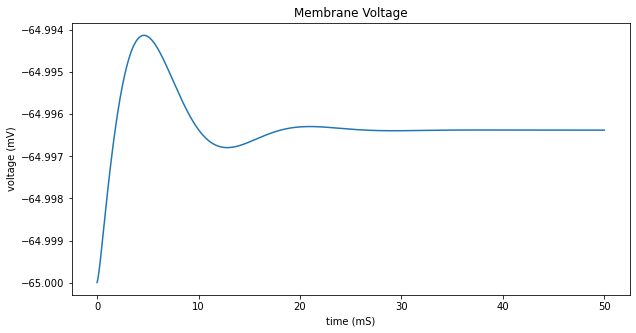

In [15]:
plt.figure(figsize=(10,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title('Membrane Voltage')
plt.plot(t,ret['v_m'])
plt.xlabel('time (mS)')
plt.ylabel('voltage (mV)')
plt.show()

## B

In [16]:
params['ie'] = 20e-12
ret = hh_euler(params, init_values, t, del_t)

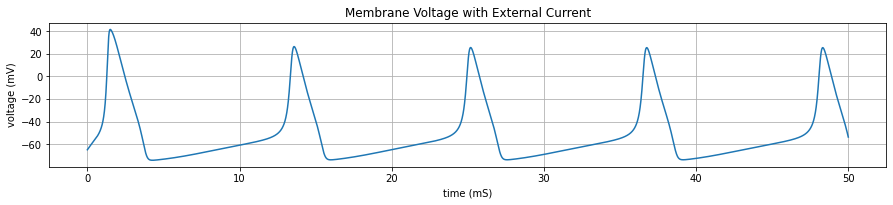

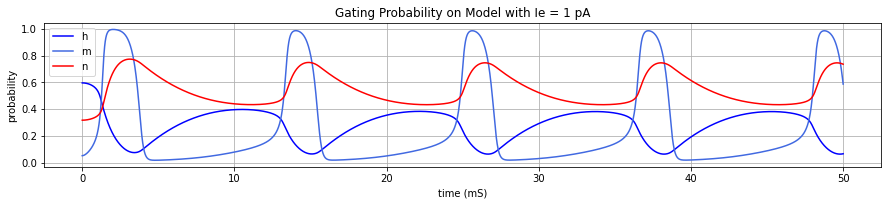

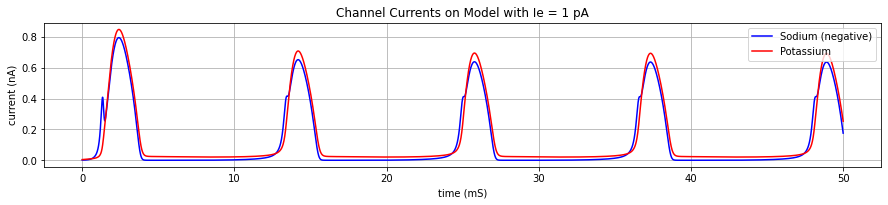

In [24]:
#ax = plt.gca()
#ax.ticklabel_format(useOffset=False)

plt.figure(figsize=(15,9))
plt.subplot(311)

plt.title('Membrane Voltage with External Current')
plt.plot(t,ret['v_m'])
plt.xlabel('time (mS)')
plt.ylabel('voltage (mV)')
plt.grid()
plt.show()


plt.figure(figsize=(15,9))
plt.subplot(312)

plt.title('Gating Probability on Model with Ie = 1 pA')
plt.xlabel('time (mS)')
plt.ylabel('probability')

plt.plot(t,ret['h'], label='h', color='blue')
plt.plot(t,ret['m'], label='m', color='royalblue')
plt.plot(t,ret['n'], label='n', color='red')

plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,9))
plt.subplot(313)

plt.title('Channel Currents on Model with Ie = 1 pA')
plt.xlabel('time (mS)')
plt.ylabel('current (nA)')

plt.plot(t,-ret['i_na']*1e9, label='Sodium (negative)', color='blue')
plt.plot(t,ret['i_k']*1e9, label='Potassium', color='red')
plt.legend()
plt.grid()
plt.show()

### Discussion
 
At the beginning of the action potential generation, the external current drives the membrane voltage equation toward a more positive potential. Then positive gradient eventually affects the gate opening porbability of both sodium and potassium channel. The sodium h probability goes up along with the gradual increase of the membrane voltage. At the same time, the n probability goes down. 

The process enters a new phase when the h is at the highest and the n at the lowest. This inititate the more negative sodium current in which drives the membrane voltage gardient to be more positive. The more positive membrane voltage yield more opening probability of the m. The m has relatively small time constant therefore the condition result in very sharp increase of the sodium current. 

The sudden increase in voltage membrane also trigger the opening of the potassium channel. Potassium channel has a negative effect toward the membrane voltage. When the membrane voltage is reaching its peak, the potassium is opening even larger. This result in decrease of the membrane voltage and returning the state into its beginning.

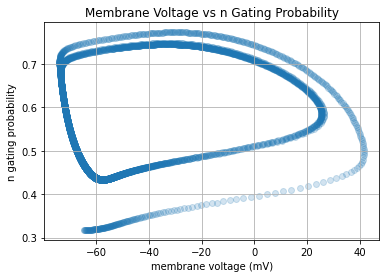

In [18]:
plt.title('Membrane Voltage vs n Gating Probability')
plt.scatter(ret['v_m'],ret['n'], alpha=0.2)
plt.xlabel('membrane voltage (mV)')
plt.ylabel('n gating probability')
plt.grid()
plt.show()

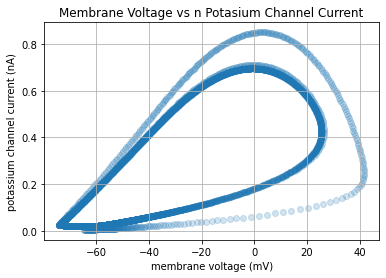

In [40]:
plt.title('Membrane Voltage vs n Potasium Channel Current')

plt.scatter(ret['v_m'],ret['i_k']*1e9, alpha=0.2)
plt.xlabel('membrane voltage (mV)')
plt.ylabel('potassium channel current (nA)')
plt.grid()
plt.show()

### Discussion

At the beginning (as noted by more translucent data points), it seems that the current and probability are monotonically increasing. However when it reaches the peak, the values go up and stay at certain points as pictured by thicker plot. The values stays at this region on loop.  

The two phase plane plots also indicate that the both current and gating probability do not only depend on the membrane voltage. It seems that the past membrane voltage has influence to the current values of gating porbability and channel current. 


## C

In [25]:
ies = np.linspace(0,20e-12,100).tolist()

vms = []
for ie in ies:
    params['ie'] = ie
    ret = hh_euler(params, init_values, t, del_t)
    vms.append(ret['v_m'])

In [26]:
def compute_firing_rate(series, t, thr=0):
    idx_thr = series > thr
    num_spikes = 0
    spike_idx = []
    for i in range(1, series.shape[0]-1):
        if idx_thr[i-1] ==False and idx_thr[i]==True:
            num_spikes+=1
            spike_idx.append(t[i])
    spike_idx = np.array(spike_idx) *1e-3 # to second
    
    if num_spikes <= 2: 
        return 0
    else:
        isi = np.mean(np.diff(spike_idx[1:]))
        return 1./isi

In [27]:
frs = []
for vm in vms:
    frs.append(compute_firing_rate(vm, t, thr=0))
frs = np.array(frs)
ies = np.array(ies)

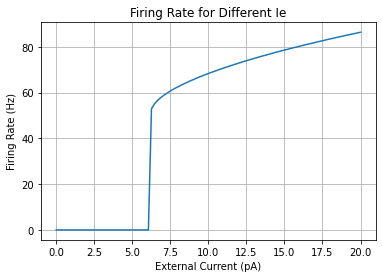

In [28]:
plt.title('Firing Rate for Different Ie')
plt.plot(ies * 1e12, frs)
plt.xlabel('External Current (pA)')
plt.ylabel('Firing Rate (Hz)')
plt.grid()

### Discussion

From the plot, it is clearly seen that the firing rate jump whenever the external current is bigger than 6 pA. 

The main diffenrence between hodgkin-huxley model (HHM) and integrate and fire neuron is that the HHM has the 'jump' while the integrate-and-fire model does not. 

In addition, the integrate and fire model seems to have a linear relationship between the input current and the firing rate for higher input current. In the HHM model, the plot has a slight curve therefore has an asymptotic point somewhere.

## D

In [41]:
params['is_ie_time_dependent'] = True        
params['t_trigger'] = 5
params['ie'] = -5e-12
params['ie_pt'] = 0

In [42]:
ret = hh_euler(params, init_values, t, del_t)

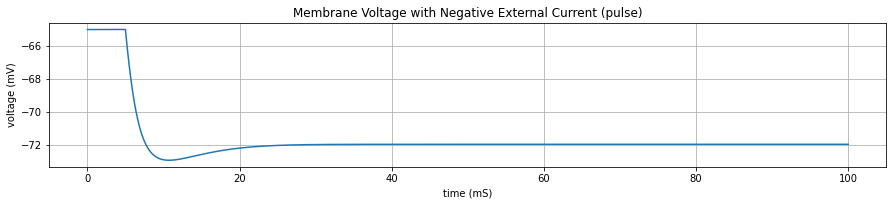

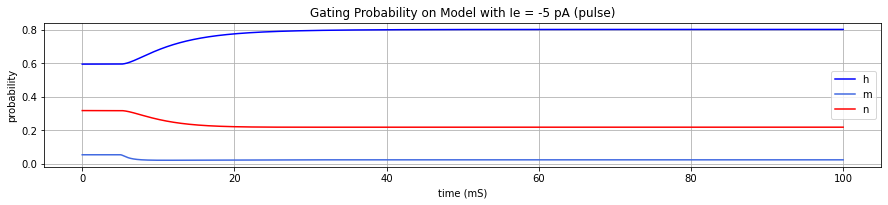

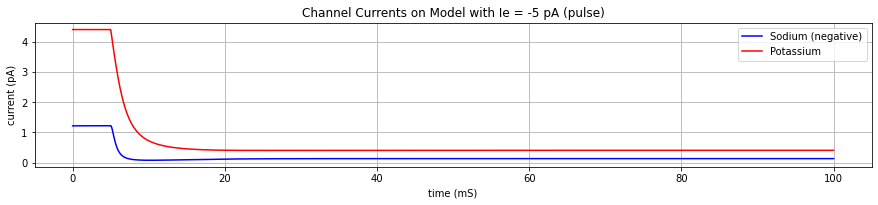

In [43]:
plt.figure(figsize=(15,9))
plt.subplot(311)

plt.title('Membrane Voltage with Negative External Current (pulse)')
plt.plot(t,ret['v_m'])
plt.xlabel('time (mS)')
plt.ylabel('voltage (mV)')
plt.grid()
plt.show()


plt.figure(figsize=(15,9))
plt.subplot(312)

plt.title('Gating Probability on Model with Ie = -5 pA (pulse)')
plt.xlabel('time (mS)')
plt.ylabel('probability')

plt.plot(t,ret['h'], label='h', color='blue')
plt.plot(t,ret['m'], label='m', color='royalblue')
plt.plot(t,ret['n'], label='n', color='red')

plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,9))
plt.subplot(313)

plt.title('Channel Currents on Model with Ie = -5 pA (pulse)')
plt.xlabel('time (mS)')
plt.ylabel('current (pA)')

plt.plot(t,-ret['i_na']*1e12, label='Sodium (negative)', color='blue')
plt.plot(t,ret['i_k']*1e12, label='Potassium', color='red')
plt.legend()
plt.grid()
plt.show()

### Discussion

The negative external current does not change anything for the first 50mS. The amount of the external voltage is not big enought to drive the voltage. However, when the external current becomes 0 suddenly, the gradient get posi


brings the membrane voltage to be more negative as shown on the membrane voltage equation. 

## E

In [39]:
params['is_ie_time_dependent'] = False
params['is_ie_external'] = True

max_freq = 100

del_t = 0.25 / max_freq
max_t = 100
t = np.arange(0, 100, step=del_t)

freqs = np.linspace(0,100,20).tolist()
frs = []
for freq in freqs:
    params['ie_func'] = 2e-12 * np.sin(2*np.pi*freq*t*1e-3)
    ret = hh_euler(params, init_values, t, del_t)
    fr = compute_firing_rate(ret['v_m'], t, thr=0)
    frs.append(fr)
frs = np.array(frs)

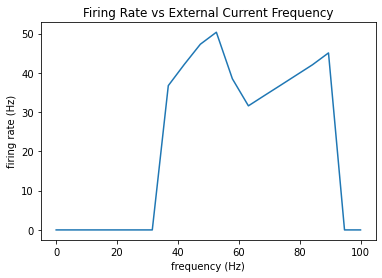

In [40]:
plt.title('Firing Rate vs External Current Frequency')

plt.plot(freqs, frs)

plt.xlabel('frequency (Hz)')
plt.ylabel('firing rate (Hz)')

plt.show()

### Discussion

